<a href="https://colab.research.google.com/github/giovannasantoloni/Projetos-de-Sistemas-Inteligentes-de-Apoio-Decis-o/blob/main/Projeto_Final_Curso_BI_Master_2021_1_Giovanna_Dohnert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Final Curso BI Master 2021-1
> Por Giovanna Santoloni Dohnert

In [1]:
#Montagem do Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importar Bibliotecas
import numpy as np
import pandas as pd
import os
import shutil
import cv2
from glob import glob
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
import random
import shutil
import zipfile


In [3]:
#Importar Aplicações
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from scipy import ndimage, misc
import skimage
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential
from keras.layers.pooling import GlobalAveragePooling2D
from keras.models.cloning import training
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Reshape
from google.colab import drive
from shutil import copyfile

In [4]:
#Caminho da Base de Dados
import os
workdir_path = '/content/drive/My Drive/Projeto Final BI/Dataset' 
os.chdir(workdir_path)

In [5]:
# Caminho do dataset
full_dataset = r'/content/drive/My Drive/Projeto Final BI/Dataset'

In [6]:
#Definição de Parâmetros

#Número de Classes 
n_classes = 10

#Tamanho das Imagens
target_size = (225, 225)

#Tamanho do Lote para Treinamento
batch_size = 32


In [7]:
# Olhando o número de arquivos por classe
for nome_pasta in os.listdir(full_dataset):
    caminho_pasta = os.path.join(full_dataset, nome_pasta)
  
    if os.path.isdir(caminho_pasta):
        
        lista_arquivos = os.listdir(caminho_pasta)  

        num_arquivos = len(lista_arquivos)     

        print("Pasta:", nome_pasta, " - Número de arquivos:", num_arquivos)

Pasta: Abyssinian  - Número de arquivos: 187
Pasta: Bengal  - Número de arquivos: 191
Pasta: Birman  - Número de arquivos: 186
Pasta: Bombay  - Número de arquivos: 179
Pasta: British Short Hair  - Número de arquivos: 165
Pasta: Egyptian Mau  - Número de arquivos: 176
Pasta: Maine Coon  - Número de arquivos: 158
Pasta: Persian  - Número de arquivos: 163
Pasta: Ragdoll  - Número de arquivos: 177
Pasta: Siamese  - Número de arquivos: 173


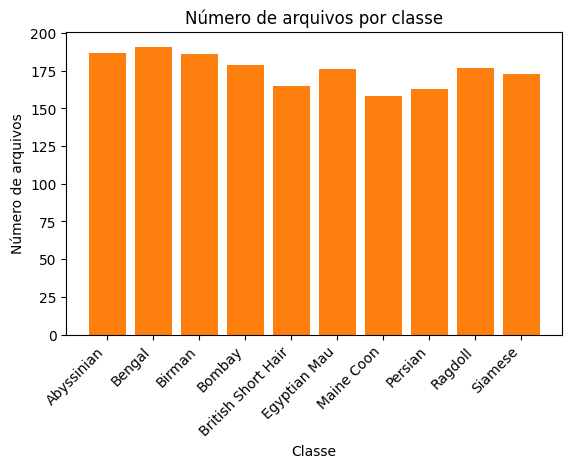

In [8]:
# Criando as listas para armazenar os dados
classes = []
num_arquivos = []

# Olhando o número de arquivos por classe
for nome_pasta in os.listdir(full_dataset):
    caminho_pasta = os.path.join(full_dataset, nome_pasta)
  
    if os.path.isdir(caminho_pasta):
        
        lista_arquivos = os.listdir(caminho_pasta)  

        num_arq = len(lista_arquivos)
        
        classes.append(nome_pasta)
        num_arquivos.append(num_arq)

# Gerando o gráfico de barras
plt.bar(classes, num_arquivos)
plt.title("Número de arquivos por classe")
plt.xlabel("Classe")
plt.ylabel("Número de arquivos")
plt.subplots_adjust(bottom=0.25)
plt.bar(classes, num_arquivos, width=0.8)
plt.xticks(rotation=45, ha="right")
plt.show()

In [9]:
# Criando o gerador de imagens com as transformações desejadas
image_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, 
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    shear_range=0.2,
    fill_mode='reflect',
    channel_shift_range=50.0,
    vertical_flip=True,
)

In [10]:
# Criando o dataset de Treino
train_dataset = image_generator.flow_from_directory(batch_size=batch_size, 
                                                    directory=full_dataset ,
                                                    shuffle=True,
                                                    target_size=target_size,
                                                    subset="training",
                                                    class_mode='categorical')

# Criando o dataset de Validação
validation_dataset = image_generator.flow_from_directory(batch_size=batch_size, 
                                                         directory=full_dataset,
                                                         shuffle=True,
                                                         target_size=target_size,
                                                         subset="validation",
                                                         class_mode='categorical')

# Criando o conjunto de Teste com mesmo tamanho do conjunto de Validação
test_dataset = image_generator.flow_from_directory(batch_size=batch_size, 
                                                    directory=full_dataset,
                                                    shuffle = True,
                                                    target_size =target_size,
                                                    class_mode = 'categorical',
                                                    subset = 'validation')

Found 1406 images belonging to 10 classes.
Found 346 images belonging to 10 classes.
Found 346 images belonging to 10 classes.


In [11]:
# Importar a arquitetura ResNet50V2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

# carregar a arquitetura ResNet50V2 pré-treinada
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(*target_size, 3))

94668760/94668760 [==============================] - 3s 0us/step


In [12]:
# adicionar camadas adicionais ao modelo
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x) 

# Adicionamos uma camada de dropout de 0,5, o que significa que metade dos neurônios da camada anterior serão aleatoriamente desativados
# durante o treinamento, para evitar overfitting.

x = Dropout(0.5)(x)  

predictions = Dense(n_classes, activation='softmax')(x)

In [13]:
# criar modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# congelar as camadas da base
for layer in base_model.layers:
    layer.trainable = False

In [14]:
# Learning Rate Fixo
lr_fixed = 1e-4

# Beta 1
beta_1 = 0.9

# compilar o modelo com a learning_rate fixa
model.compile(optimizer=Adam(learning_rate=lr_fixed, beta_1=beta_1), loss='categorical_crossentropy', metrics=['acc'])

In [15]:
# Treinar o Modelo
history = model.fit(
    train_dataset,
    steps_per_epoch=(batch_size),
    epochs=50,
    validation_data=validation_dataset,
    validation_steps=len(validation_dataset))

Epoch 1/50
32/32 [==============================] - 618s 19s/step - loss: 2.9544 - acc: 0.3728 - val_loss: 0.8984 - val_acc: 0.6908
Epoch 2/50
32/32 [==============================] - 140s 4s/step - loss: 1.2996 - acc: 0.5881 - val_loss: 0.7040 - val_acc: 0.7630
Epoch 3/50
32/32 [==============================] - 58s 2s/step - loss: 1.2436 - acc: 0.5998 - val_loss: 0.6105 - val_acc: 0.7832
Epoch 4/50
32/32 [==============================] - 38s 1s/step - loss: 1.0449 - acc: 0.6670 - val_loss: 0.6765 - val_acc: 0.7688
Epoch 5/50
32/32 [==============================] - 32s 995ms/step - loss: 0.9866 - acc: 0.6846 - val_loss: 0.6655 - val_acc: 0.7688
Epoch 6/50
32/32 [==============================] - 30s 936ms/step - loss: 0.9199 - acc: 0.6888 - val_loss: 0.6381 - val_acc: 0.7746
Epoch 7/50
32/32 [==============================] - 29s 922ms/step - loss: 0.9183 - acc: 0.6859 - val_loss: 0.5403 - val_acc: 0.8064
Epoch 8/50
32/32 [==============================] - 30s 947ms/step - loss: 0.9

In [16]:
# Avaliando o modelo com conjunto de teste
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_dataset.classes

11/11 [==============================] - 7s 604ms/step


In [17]:
# Gerando a Matriz de Confusão
conf_matrix = confusion_matrix(y_true, y_pred)
print("Matriz de Confusão:\n", conf_matrix)

Matriz de Confusão:
 [[3 5 2 4 2 6 3 3 5 3]
 [1 5 5 2 2 3 5 4 8 3]
 [4 3 7 2 7 3 1 2 3 5]
 [4 5 3 5 0 4 2 5 2 5]
 [5 7 7 4 1 3 1 0 3 2]
 [1 2 4 4 6 6 1 2 5 4]
 [4 2 3 3 5 5 1 1 4 3]
 [3 5 5 4 2 3 1 5 3 1]
 [3 5 2 7 1 3 7 3 2 2]
 [1 5 3 1 3 3 4 6 4 4]]


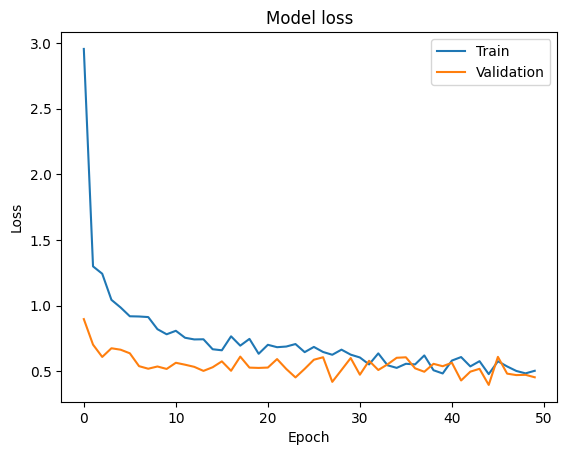

In [18]:
# Plotar o gráfico de loss durante o treinamento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()